In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from math import sqrt
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [1]:
import os 
  
# current directory 
current_dir = os.getcwd() 
relative_path=os.path.abspath(os.path.join(current_dir, os.pardir))

Read data

In [2]:
df = pd.read_csv(
    relative_path+"\\age_structure_data\\WPP2022_Demographic_Indicators_Medium.csv")

In [3]:
df_population = pd.read_csv(
    relative_path+"\\age_structure_data\\df_full.csv")

In [4]:
df_population['Year'] = pd.to_datetime(df_population['Year'])
df_population = df_population.set_index("Year")

In [5]:
df_population['all']=df_population['elder']+df_population['youth']+df_population['youth']

In [6]:
df_real = df_population.loc[df_population.index > '2009-01-01']
df_real=df_real['all']

In [7]:
df_population = df_population.loc[df_population.index < '2010-01-01']


In [8]:
df_population=df_population['all']

Filter data, set index in datetime 

Stationary Check

In [9]:
def stationary_test(df):
   
    # Check using adftest
    result = adfuller(df)
    print('p :', result[1])  # if p<0.05 and
    # adf lower than critical values, reject null hypotheses, stationary
    print('adf statistic :', result[0])
    print('critical value :')
    for key, value in result[4].items():
        print(key, value)

In [10]:
df_population.dropna(inplace=True)
stationary_test(df_population)

p : 0.9988016476251742
adf statistic : 2.1117264153580004
critical value :
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338


In [11]:
df_population_differenced = df_population-df_population.shift()
df_population_differenced.dropna(inplace=True)
stationary_test(df_population_differenced)

p : 0.8181245172813072
adf statistic : -0.8033891005664915
critical value :
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338


In [12]:
df_population_differenced2 = df_population_differenced-df_population_differenced.shift()
df_population_differenced2.dropna(inplace=True)
stationary_test(df_population_differenced2)

p : 6.982538976638411e-06
adf statistic : -5.248844397245516
critical value :
1% -3.5925042342183704
5% -2.931549768951162
10% -2.60406594375338


In [13]:
cv1_train_population, cv1_test_population = train_test_split(df_population, test_size=0.2, shuffle=False)
cv2_train_population, cv2_test_population = train_test_split(cv1_train_population, test_size=0.2, shuffle=False)
cv3_train_population, cv3_test_population = train_test_split(cv2_train_population, test_size=0.15, shuffle=False)

In [14]:
def find_best_pdq(train_data, test_data):
    df_search = pd.DataFrame()
    for p in range(6):
        for q in range(6):
            arima_model = ARIMA(train_data, order=(p, 2, q)).fit()
                # predict from the position of test data which is length of train data
            prediction = arima_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
            rmse = sqrt(mean_squared_error(test_data, prediction))
            df_search = df_search.append({'pdq_paramters': str(p)+" "+"2"+" "+str(q), 'rmse': rmse}, ignore_index=True)
    return df_search
    #print(df_search.sort_values('rmse', ascending=True).head())
    # print()

In [15]:
df_cv1=find_best_pdq(cv1_train_population, cv1_test_population)
df_cv2=find_best_pdq(cv2_train_population, cv2_test_population)
df_cv3=find_best_pdq(cv3_train_population, cv3_test_population)

concatenated = pd.concat([df_cv1, df_cv2, df_cv3])
concatenated=concatenated.groupby('pdq_paramters').mean()
concatenated.sort_values('rmse', ascending=True)

,rmse
pdq_paramters,
3 2 5,1.494844e+05
5 2 5,1.944671e+05
5 2 4,1.999555e+05
2 2 5,2.107421e+05
2 2 4,2.463026e+05
5 2 0,2.464555e+05
5 2 2,2.464778e+05
1 2 0,2.464982e+05
0 2 1,2.464986e+05


In [16]:
population_arima_model = ARIMA(df_population, order=(3, 2, 5)).fit()
population_prediction = population_arima_model.predict(
    start=len(df_population), end=len(df_population)+11)


In [17]:

population_prediction = population_prediction.to_frame()
population_prediction.rename(columns = {'predicted_mean':'all'}, inplace = True)
population_prediction.index = pd.to_datetime(population_prediction.index)

In [18]:
df_population=df_population.to_frame()
df_population.index = pd.to_datetime(df_population.index)

In [19]:
population_final = pd.concat([df_population, population_prediction])

<function matplotlib.pyplot.show(close=None, block=None)>

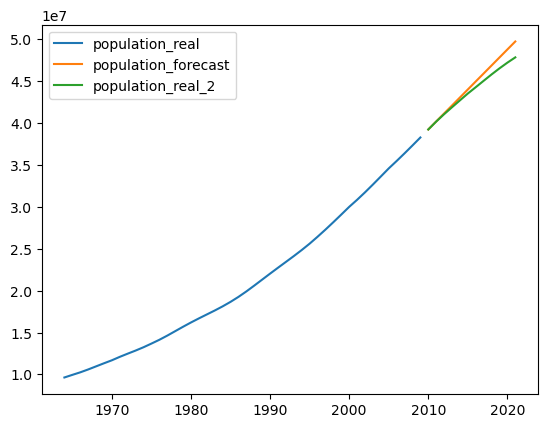

In [20]:
plt.plot(df_population,label="population_real")

plt.plot(population_prediction,label="population_forecast")
plt.plot(df_real,label="population_real_2")
plt.legend(loc='best')
plt.show

In [21]:
population_final.to_csv(relative_path+"\\age_structure_data\\population_with_forecast.csv")